## Simple qubit rotation with Pennylane and TFQ

In this jupyter file we define a variational quantum circuit $V(\theta)$ that rotates an initial state $|0000\rangle$ into a target state with equal superposition $\frac{1}{\sqrt{|\Sigma|}}\sum_{\sigma_i} | \sigma_i \rangle$. The aim is that  $\frac{1}{\sqrt{|\Sigma|}}\sum_{\sigma_i} \langle \sigma_i | V(\theta) | 0000\rangle = 1$.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from tqdm.notebook import tqdm

## Pennylane version

Define the device `default.qubit` and a circuit where one layer contains a general rotation $R(\phi, \theta, \omega) = R_z(\omega)R_x(\theta)R_z(\phi)$ on each qubit, followed by entangling gates. We apply 2 layers. The $R(\phi, \theta, \omega)$ gate is a native in pennylane `qml.Rot()`. We use 4 qubits.

In [2]:
dev1 = qml.device("default.qubit", wires=4)

In [3]:
target_state = np.ones(2**4)/np.sqrt(2**4)
density = np.outer(target_state, target_state)

@qml.qnode(dev1)
def circuit(params):
    for j in range(2): # 2 layers
        for i in range(4): # 4 qubits
            qml.Rot(*params[j][i], wires=i)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[2,3])
        qml.CNOT(wires=[1,2])
    return qml.expval(qml.Hermitian(density, wires=[0,1,2,3]))

Define a cost function. In our case we want the overlap of the circuit output to be maximal with the targe_state. Therefore we minimize $1-\frac{1}{\sqrt{|\Sigma|}}\sum_{\sigma_i}\langle \sigma_i | V(\theta) | 0000\rangle$

In [4]:
def cost(var):
    return 1-circuit(var)

Initialize the parameters randomly. The shape of the parametrs is $(layers, number of qubits, 3)$ because for each layer and qubit we have 3 paramters.

In [5]:
init_params = np.random.rand(2, 4, 3) # 2 layers, 4 qubits, 3 parameters per rotation
print(cost(init_params))

0.9791545794006542


### Training

For the training we define a gradient descent optimizer and continuously update the parameters 

In [6]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4) # stepsize is the learning rate

# set the number of steps
steps = 100
# set the initial parameter values
params = init_params

for i in tqdm(range(steps)):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i + 1) % 10 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

/home/apozas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Cost after step    10:  0.7926067
Cost after step    20:  0.1511231
Cost after step    30:  0.0142782
Cost after step    40:  0.0049359
Cost after step    50:  0.0024388
Cost after step    60:  0.0013136
Cost after step    70:  0.0007371
Cost after step    80:  0.0004231
Cost after step    90:  0.0002461
Cost after step   100:  0.0001442

Optimized rotation angles: [[[ 4.37680865e-01  5.83405123e-09  3.20036600e-01]
  [ 5.87685497e-01 -5.85645201e-08 -2.78093370e-02]
  [ 9.77501871e-02 -4.70612985e-02  5.59492498e-01]
  [ 3.37501386e-01  1.05926966e+00 -7.16822962e-02]]

 [[ 9.64584837e-01  1.57079632e+00  3.82648191e-09]
  [ 6.43859415e-01  1.57079627e+00 -2.28028241e-08]
  [ 1.10680485e+00  1.56630413e+00  4.68466476e-02]
  [ 2.36741061e-01  5.17397955e-01 -1.43807908e-01]]]


If we check the final state we see that appart from a global pahse we find the target state.

In [7]:
circuit(params)
dev1.state

array([-0.21085093-0.13604769j, -0.20637046-0.13970451j,
       -0.20998474-0.13732926j, -0.20530324-0.14079939j,
       -0.20998475-0.13732924j, -0.20530324-0.14079937j,
       -0.21085091-0.13604769j, -0.20637045-0.1397045j ,
       -0.21085091-0.13604769j, -0.20637044-0.1397045j ,
       -0.20998474-0.13732924j, -0.20530324-0.14079937j,
       -0.20998474-0.13732926j, -0.20530323-0.14079939j,
       -0.21085093-0.13604769j, -0.20637046-0.1397045j ])

## TFQ version

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import tensorflow.keras as keras

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

### Generate symbols

I did not figure out, how I can do the gradients in TFQ without using symbols, this seems to be mandatory for tfq. I don't reallay see the advantage so far. Especially the evaluation with the resolver function seems a bit odd and unnecessary.

The definition of the circuit is almost the same as in Pennylane.

There is no option to define a projections operator to calculate the overlap with a target state because they are not unitary. This gives a bit less room to play with TFQ. I assume the idea was, that these gates are not really feasible on a real quantum device.

Instead of defining a hermitian matrix that gives the overlap with the target state, we can simply measure the operator $M = 1/4*(X_1 + X_2 + X_3 + X_4)$ and minimize the loss $1-\langle M \rangle$.

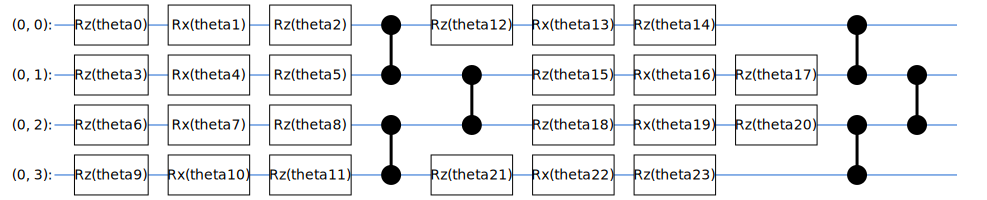

In [2]:
def generate_circuit(nr_of_qubits, layers):
    qubits = cirq.GridQubit.rect(1, nr_of_qubits) # Define qubit grid. In this case 
    nr_parameters = 3*nr_of_qubits*layers # 3 params for each qubit and layer

    symb = sympy.symbols('theta0:'+str(nr_parameters))
    symbols = np.array(symb)
    symbols = symbols.reshape(layers, nr_of_qubits, 3)
    circuit = cirq.Circuit()

    for l in range(layers):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            circuit += cirq.rz(symbols[l][i][0])(qubit)
            circuit += cirq.rx(symbols[l][i][1])(qubit)
            circuit += cirq.rz(symbols[l][i][2])(qubit)

        circuit += cirq.CZ(qubits[0], qubits[1])
        circuit += cirq.CZ(qubits[2], qubits[3])
        circuit += cirq.CZ(qubits[1], qubits[2])

    op = 1/4*(cirq.X(qubits[0]) + cirq.X(qubits[1]) + cirq.X(qubits[2]) + cirq.X(qubits[3]))         
    return circuit, op, list(symb)

nr_of_qubits = 4
layers = 2
tf_circuit, op, (symbols) = generate_circuit(nr_of_qubits, layers)
SVGCircuit(tf_circuit) 

### Training

One can leverage all the Tensorflow machinery for training quantum circuits. We will now insert the previous circuit in a ``tf.keras`` model in order to train it.

First of all, the circuit must be converted into a layer so it can be inserted in a model. The most direct choice is the ``PQC`` (which stands for Parameterized Quantum Circuit) layer. This layer requires as additional specifications the operator we are going to measure in the end, the number of evaluations, and the way the gradients are going to be computed.

In [3]:
outputs = tfq.layers.PQC(tf_circuit,         # Circuit to be transformed into tf layer
                         1-op)

Next, we can instantiate a model, taking an arbitrary input and outputting the result of the measurement of $M$

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    outputs
])

In order to compile and fit the model, one needs to define a loss function (the quantity to optimize) and an optimizer. We want to optimize the expectation value of $M$, this is, the output of the model. Tensorflow needs this, however, as a function ``f(real_values,predictions)``

In [5]:
def loss(real, pred):
    return pred

In [6]:
model.compile(loss=loss,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.4)) # Same optimizer as the Pennylane case

Finally, the ``fit`` function is designed for classification problems, and thus it needs of some inputs and corresponding "true" outputs. Our variational quantum circuit has none of these, so we just insert empty attributes: the input will be an empty quantum circuit, which corresponds to setting the initial state to $|0000\rangle$; the output will be an empty array (you can choose anything you want, since the loss function will discard whatever you set)

In [7]:
dummy_input  = tfq.convert_to_tensor([cirq.Circuit()])
dummy_output = np.array([[]])

An it is finally time to train!

In [8]:
steps = 100
model.fit(dummy_input, dummy_output, epochs=steps)

Train on 1 samples
Epoch 1/100
1/1 [==============================] - 1s 1s/sample - loss: 0.9933
Epoch 2/100
1/1 [==============================] - 0s 18ms/sample - loss: 0.9418
Epoch 3/100
1/1 [==============================] - 0s 13ms/sample - loss: 0.8874
Epoch 4/100
1/1 [==============================] - 0s 17ms/sample - loss: 0.8304
Epoch 5/100
1/1 [==============================] - 0s 15ms/sample - loss: 0.7716
Epoch 6/100
1/1 [==============================] - 0s 13ms/sample - loss: 0.7119
Epoch 7/100
1/1 [==============================] - 0s 12ms/sample - loss: 0.6525
Epoch 8/100
1/1 [==============================] - 0s 14ms/sample - loss: 0.5941
Epoch 9/100
1/1 [==============================] - 0s 14ms/sample - loss: 0.5377
Epoch 10/100
1/1 [==============================] - 0s 18ms/sample - loss: 0.4841
Epoch 11/100
1/1 [==============================] - 0s 25ms/sample - loss: 0.4343
Epoch 12/100
1/1 [==============================] - 0s 16ms/sample - loss: 0.3890
Epoch 13

Epoch 99/100
1/1 [==============================] - 0s 19ms/sample - loss: 7.5698e-06
Epoch 100/100
1/1 [==============================] - 0s 20ms/sample - loss: 6.7353e-06


Like in the Hello World example we can extract the wave function we see that we get the equal superposition state with some global phase.

In [15]:
simulator = cirq.Simulator()
dictionary = {symb: model.trainable_variables[0].numpy()[i] for i, symb in enumerate(symbols)}
resolver = cirq.ParamResolver(dictionary)
resolved_circuit = cirq.resolve_parameters(tf_circuit, resolver)
output_state_vector = simulator.simulate(tf_circuit, resolver).final_state
output_state_vector

array([-0.00286266+0.01872098j, -0.00046927+0.2587476j ,
       -0.0138061 +0.10716106j,  0.0847271 -0.19069251j,
        0.05543072-0.0915546j ,  0.00039238-0.29273975j,
       -0.02523318+0.16849318j,  0.265944  -0.46552533j,
        0.08174167+0.0482669j ,  0.17641312+0.06576671j,
        0.11405597+0.04105367j, -0.3545978 -0.23970872j,
        0.03512595-0.02338716j,  0.09215477-0.29585007j,
       -0.06562621+0.1250625j ,  0.2509636 -0.20192285j], dtype=complex64)